In [61]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean
from sklearn.metrics import mean_squared_error
from math import sqrt

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/']

input_names = ['HIST']
climatology_files = ['clt_MODIS_yearmean.nc']
climatology_path = '/p/project/chhb19/streffing1/obs/MODIS/'
exps = range(7, 9)
figsize=(6, 4.5)
dpi = 300
ofile = None
res = [180, 91]
variable = ['TCC']
variable_clim = 'clt'
title='Cloud area fraction vs. MODIS'
mapticks = [-50,-30,-20,-10,-6,-2,2,6,10,20,30,50]

contour_outline_thickness = 0
levels = np.linspace(-5, 5, 21)


In [3]:
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [26]:
# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())



In [62]:
# Mean Deviation weighted
def md(predictions, targets, wgts):
    output_errors = np.average((predictions - targets), axis=0, weights=wgts)
    return (output_errors).mean()


In [59]:
mdval2 = md(crf_sw_model_mean[exp_name],crf_sw_satobs_mean,wgts)


In [6]:
# Load CERES satobs data (https://doi.org/10.1175/JCLI-D-17-0208.1)

CERES_path = climatology_path+climatology_files[0]
CERES_Dataset = Dataset(CERES_path)
CERES_Data = OrderedDict()
CERES_CRF = CERES_Dataset.variables[variable_clim][:]

In [7]:
# Load model data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:
        paths = []
        data[exp_name][v] = []
        for exp in tqdm.tqdm(exps):
            path = exp_path+'/'+v+'_'+f'{exp:05d}.nc'
            data[exp_name][v].append(cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=v)*100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


(91, 180)
(91, 180)
(91, 181)
(91, 181)


/p/project/chhb19/jstreffi/software/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
convert: unable to open image 'TCC_vs_MODIS': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `TCC_vs_MODIS_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'TCC_vs_MODIS_trimmed.png': No such file or directory


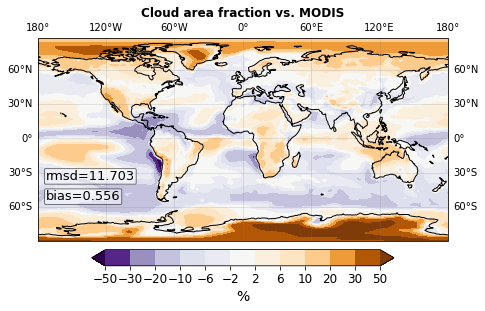

In [63]:
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()


for exp_name in input_names:
    crf_sw_model[exp_name] = np.squeeze(data[exp_name]['TCC']) 
    crf_sw_model_mean[exp_name] = np.mean(crf_sw_model[exp_name],axis=0)
    if len(np.shape(crf_sw_model_mean[exp_name])) > 2:
        crf_sw_model_mean[exp_name] = np.mean(crf_sw_model_mean[exp_name],axis=0)
crf_sw_satobs_mean = np.mean(CERES_CRF,axis=0)

print(np.shape(crf_sw_model_mean[exp_name]))
print(np.shape(crf_sw_satobs_mean))

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 180/91)
crf_sw_model_mean[exp_name], lon = add_cyclic_point(crf_sw_model_mean[exp_name], coord=lon)

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 180/91)
crf_sw_satobs_mean, lon = add_cyclic_point(crf_sw_satobs_mean, coord=lon)

print(np.shape(crf_sw_model_mean[exp_name]))
print(np.shape(crf_sw_satobs_mean))


coslat = np.cos(np.deg2rad(lat))
wgts = np.squeeze(np.sqrt(coslat)[..., np.newaxis])
rmsdval = sqrt(mean_squared_error(crf_sw_model_mean[exp_name],crf_sw_satobs_mean,sample_weight=wgts))
mdval = md(crf_sw_model_mean[exp_name],crf_sw_satobs_mean,wgts)



nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    
    
    imf=plt.contourf(lon, lat, crf_sw_model_mean[exp_name]-
                     crf_sw_satobs_mean, cmap='PuOr_r', 
                     levels=mapticks, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, crf_sw_model_mean[exp_name]-
                    crf_sw_satobs_mean, colors=line_colors, 
                    levels=mapticks, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('W/m²')
    axes[i].set_xlabel('Simulation Year')
    
    axes[i].set_title(title,fontweight="bold")
    plt.tight_layout() 
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False
    
    textrsmd='rmsd='+str(round(rmsdval,3))
    textbias='bias='+str(round(mdval,3))
    props = dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.5)
    axes[i].text(0.02, 0.35, textrsmd, transform=axes[i].transAxes, fontsize=13,
        verticalalignment='top', bbox=props, zorder=4)
    axes[i].text(0.02, 0.25, textbias, transform=axes[i].transAxes, fontsize=13,
        verticalalignment='top', bbox=props, zorder=4)
    
    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=mapticks)
    cb.set_label(label="%", size='14')
    cb.ax.tick_params(labelsize='12')

ofile=variable[0]+'_vs_MODIS'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')

In [47]:
mdval

3.3884737821535484

In [48]:
mdval2

array([4.04136181e-10, 9.59507578e-03, 1.35654429e-02, 1.66059539e-02,
       1.91615641e-02, 2.14041075e-02, 2.34213605e-02, 2.52652074e-02,
       2.69692524e-02, 2.85566745e-02, 3.00442160e-02, 3.14444026e-02,
       3.27668688e-02, 3.40191918e-02, 3.52074417e-02, 3.63365557e-02,
       3.74106018e-02, 3.84329689e-02, 3.94065070e-02, 4.03336323e-02,
       4.12164083e-02, 4.20566076e-02, 4.28557617e-02, 4.36151998e-02,
       4.43360801e-02, 4.50194159e-02, 4.56660957e-02, 4.62769011e-02,
       4.68525211e-02, 4.73935638e-02, 4.79005663e-02, 4.83740040e-02,
       4.88142971e-02, 4.92218170e-02, 4.95968916e-02, 4.99398096e-02,
       5.02508248e-02, 5.05301586e-02, 5.07780037e-02, 5.09945257e-02,
       5.11798657e-02, 5.13341415e-02, 5.14574495e-02, 5.15498654e-02,
       5.16114452e-02, 5.16422258e-02, 5.16422258e-02, 5.16114452e-02,
       5.15498654e-02, 5.14574495e-02, 5.13341415e-02, 5.11798657e-02,
       5.09945257e-02, 5.07780037e-02, 5.05301586e-02, 5.02508248e-02,
      